In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
#import loompy
import matplotlib as mpl
import harmonypy as hm
import matplotlib.pyplot as plt

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.settings.set_figure_params(dpi=80, color_map='viridis')
#sc.logging.print_versions()

### PKU,Sanger and Vienna

In [2]:
adata_pku = sc.read_h5ad('/lustre/scratch117/cellgen/team205/rl20/CTCL/PKU_object/MF_tumourcell.h5ad')
adata1 = sc.read_h5ad('/lustre/scratch117/cellgen/team205/rl20/CTCL/object-new/Tumourcell_raw_no_nan.h5ad')
adata2 = sc.read_h5ad('/lustre/scratch117/cellgen/team205/rl20/CTCL/download_dataset/GSE173205/GSE173205_raw_Tumorcell_rmdou_new.h5ad')

In [3]:
adata2.X.expm1().sum(axis = 1) ##check raw counts??

/home/jovyan/my-conda-envs/myenv_old/lib/python3.7/site-packages/scipy/sparse/data.py:133: RuntimeWarning: overflow encountered in expm1
  result = op(self._deduped_data())


matrix([[          inf],
        [          inf],
        [          inf],
        ...,
        [1.4093490e+22],
        [2.3142249e+34],
        [5.6857206e+24]], dtype=float32)

In [4]:
adatas = [adata_pku, adata1, adata2]

In [5]:
adata = adatas[0].concatenate(adatas[1:], join='inner', batch_key="dataset",
                           index_unique= '-', batch_categories=['PKU','Sanger_Ncl','Vienna'])

In [6]:
save_file = '/lustre/scratch117/cellgen/team205/rl20/CTCL/object-new/CTCL_tumourcell_sanger_PKU_Vienna_raw_rmdou.h5ad'
adata.write(save_file)

... storing 'donor_id' as categorical
... storing 'sample_type' as categorical
... storing 'sample_id' as categorical
... storing 'Tissue' as categorical
... storing 'batch' as categorical
... storing 'integrated_sample_id' as categorical
... storing 'broad_cell_type' as categorical
... storing 'LR_pre_pre' as categorical
... storing 'LR_pre_post' as categorical
... storing 'type' as categorical
... storing 'sample' as categorical


#### Process

In [7]:
input_file = '/lustre/scratch117/cellgen/team205/rl20/CTCL/object-new/CTCL_tumourcell_sanger_PKU_Vienna_raw_rmdou.h5ad'
adata = sc.read_h5ad(input_file)

In [9]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
mito_genes = adata.var_names.str.startswith('MT-')
ribo_genes = adata.var_names.str.startswith('RPS','RPL')
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
adata.obs['percent_ribo'] = np.sum(adata[:, ribo_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

filtered out 280 genes that are detected in less than 3 cells


... storing 'mad_prd' as categorical
... storing 'Status' as categorical
... storing 'Site' as categorical
... storing 'Enrichment' as categorical
... storing 'Location' as categorical
... storing 'Sex' as categorical
... storing 'stage' as categorical
... storing 'full_clustering' as categorical


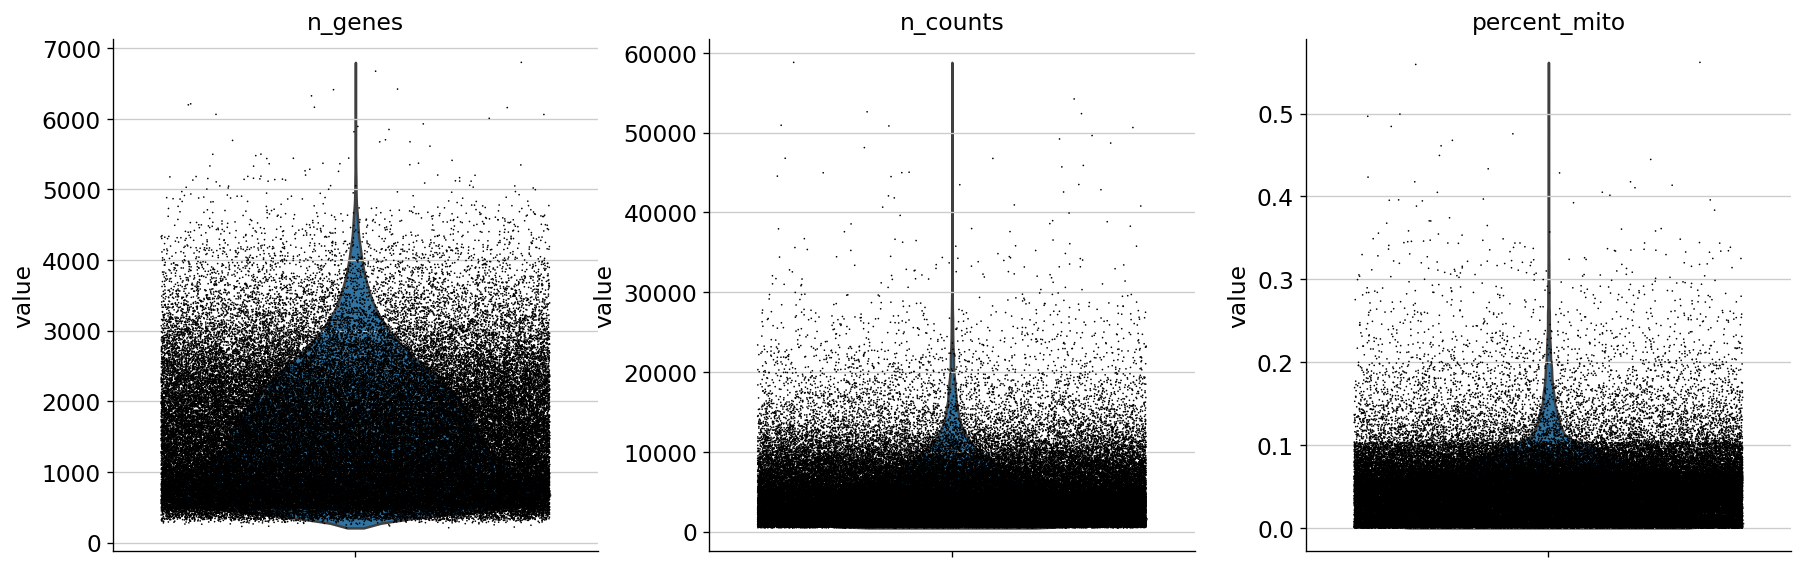

In [10]:
sc.settings.set_figure_params(dpi=60, facecolor='white')
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

In [11]:
adata = adata[adata.obs['percent_mito'] < 0.4, :]
adata.X.shape

(92455, 16601)

In [12]:
adata_backup_raw = adata.copy()
sc.pp.normalize_per_cell(adata, counts_per_cell_after = 1e4)
sc.pp.log1p(adata)
adata.raw = adata

normalizing by total count per cell


Trying to set attribute `.obs` of view, copying.


    finished (0:00:04): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


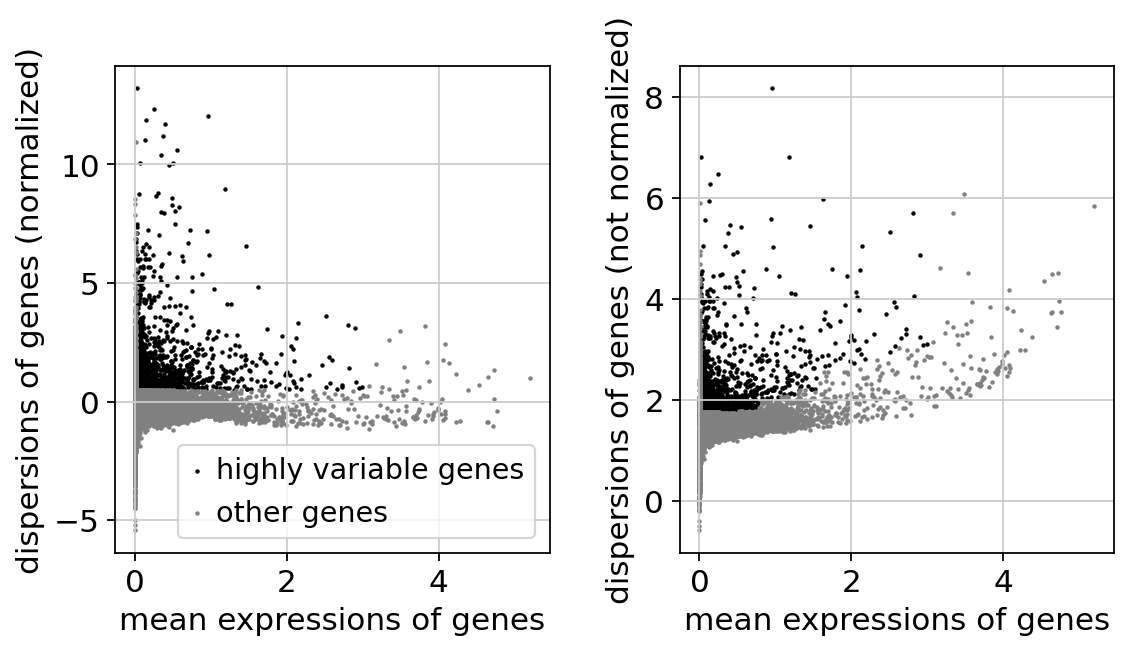

In [13]:
sc.settings.set_figure_params(dpi=80, facecolor='white')
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [14]:
adata_filtered = adata[:, adata.var['highly_variable']]

In [15]:
sc.pp.regress_out(adata_filtered, ['percent_mito', 'percent_ribo']) ### slow

regressing out ['percent_mito', 'percent_ribo']
    sparse input is densified and may lead to high memory use
    finished (0:06:08)


In [16]:
sc.pp.scale(adata_filtered, max_value=10)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:24)


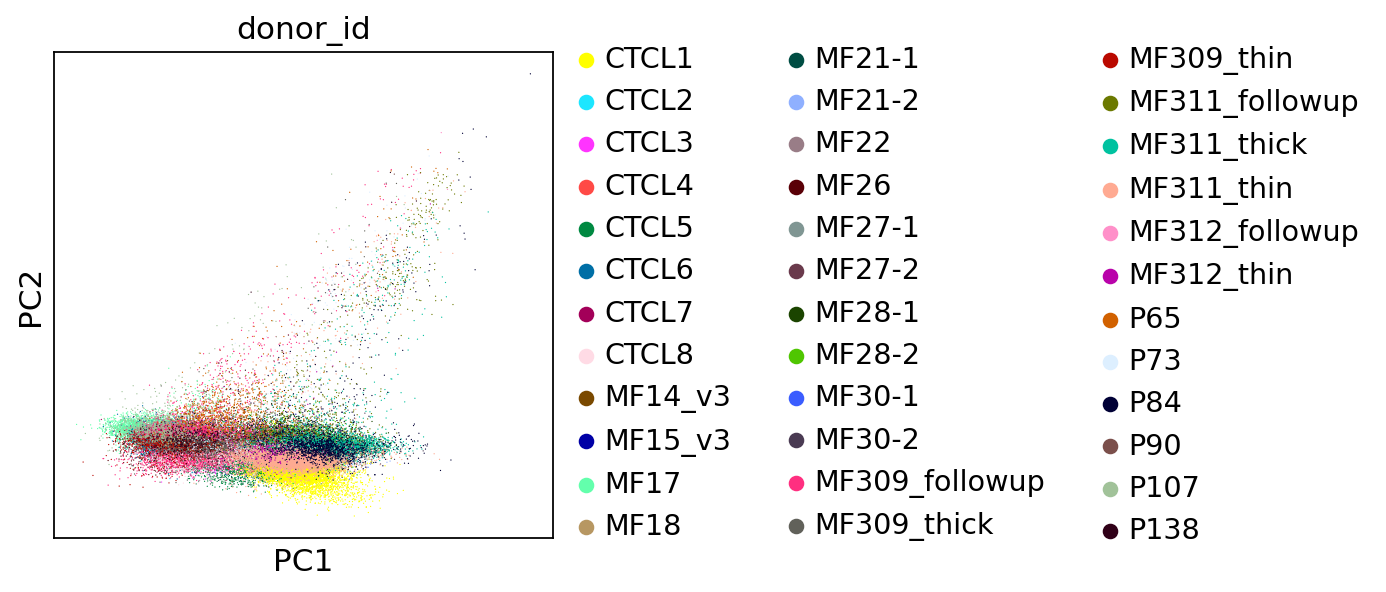

In [17]:
sc.tl.pca(adata_filtered, n_comps=50)
sc.pl.pca(adata_filtered, color = ['donor_id'])

In [18]:
adata_filtered_harmony = adata_filtered.copy()

In [19]:
#Set harmony variables
pca = np.array(adata_filtered_harmony.obsm["X_pca"])
batch = adata_filtered_harmony.obs['donor_id']
meta_data = adata_filtered_harmony.obs

#Run Harmony
ho = hm.run_harmony(pca, meta_data, ['donor_id'], theta = 3, random_state = 1234)
res = (pd.DataFrame(ho.Z_corr)).T
res.columns = ['X{}'.format(i + 1) for i in range(res.shape[1])]

#Insert coordinates back into object
adata_filtered_harmony.obsm["X_pca_back"]= adata_filtered_harmony.obsm["X_pca"][:]
adata_filtered_harmony.obsm["X_pca"] = np.array(res)

2022-02-10 15:26:31,514 - harmonypy - INFO - Iteration 1 of 10
2022-02-10 15:29:02,113 - harmonypy - INFO - Iteration 2 of 10
2022-02-10 15:31:32,697 - harmonypy - INFO - Iteration 3 of 10
2022-02-10 15:34:03,392 - harmonypy - INFO - Iteration 4 of 10
2022-02-10 15:36:20,805 - harmonypy - INFO - Iteration 5 of 10
2022-02-10 15:38:07,488 - harmonypy - INFO - Iteration 6 of 10
2022-02-10 15:39:47,008 - harmonypy - INFO - Iteration 7 of 10
2022-02-10 15:41:16,789 - harmonypy - INFO - Iteration 8 of 10
2022-02-10 15:42:46,817 - harmonypy - INFO - Iteration 9 of 10
2022-02-10 15:44:08,794 - harmonypy - INFO - Iteration 10 of 10
2022-02-10 15:45:31,988 - harmonypy - INFO - Converged after 10 iterations


In [20]:
sc.pp.neighbors(adata_filtered_harmony, n_neighbors=15, n_pcs=50, random_state = 1234)
sc.tl.umap(adata_filtered_harmony)

computing neighbors
    using 'X_pca' with n_pcs = 50


/home/jovyan/my-conda-envs/myenv_old/lib/python3.7/site-packages/numba/core/typed_passes.py:327: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../my-conda-envs/myenv_old/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/jovyan/my-conda-envs/myenv_old/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../my-c

    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:52)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:43)


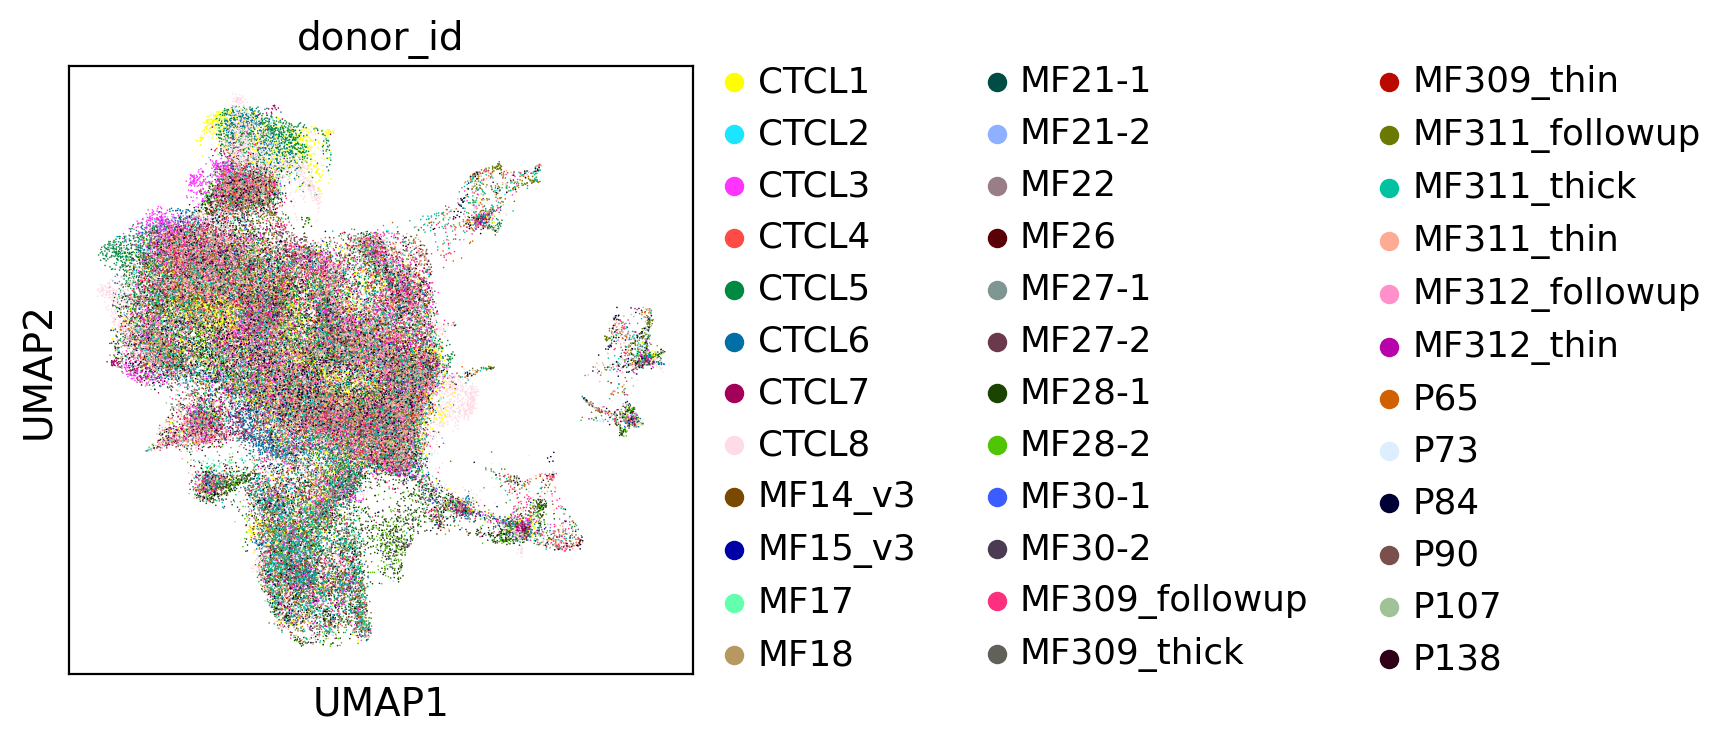

In [21]:
sc.settings.set_figure_params(dpi=100, facecolor='white')
sc.pl.umap(adata_filtered_harmony, color=['donor_id'])

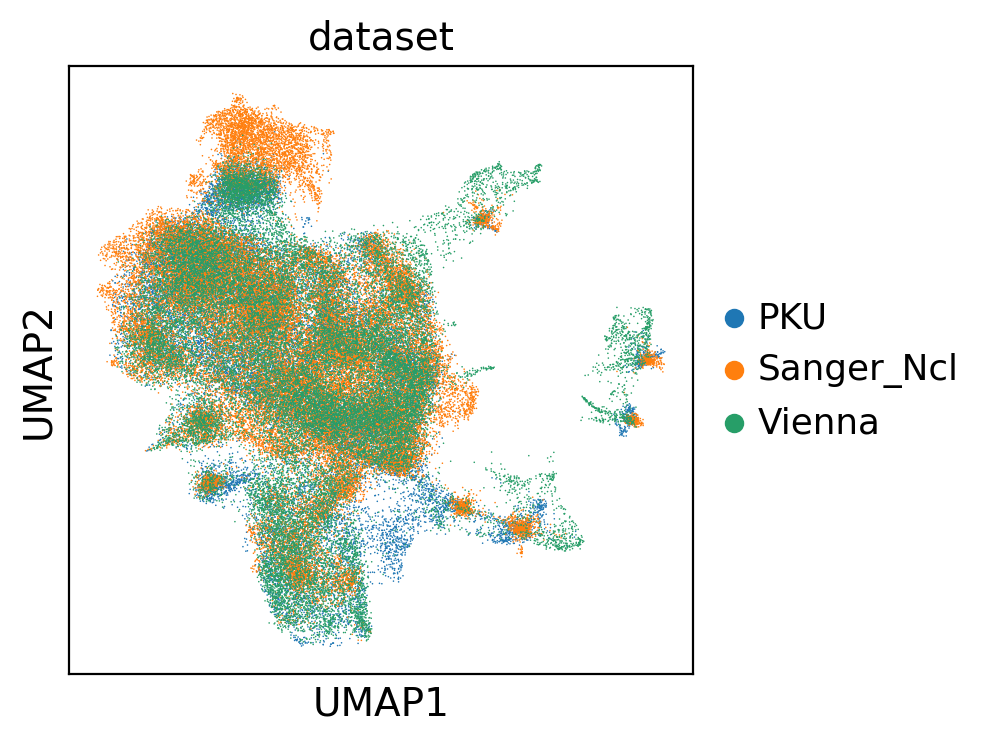

In [22]:
sc.pl.umap(adata_filtered_harmony, color=['dataset'])

In [24]:
save_file = '/lustre/scratch117/cellgen/team205/rl20/CTCL/object-new/CTCL_tumourcell_sanger_PKU_Vienna_processed_harmony_rmdou.h5ad'
adata_filtered_harmony.write(save_file)

#### DEGs stage

In [2]:
input_file = '/lustre/scratch117/cellgen/team205/rl20/CTCL/object-new/CTCL_tumourcell_sanger_PKU_Vienna_processed_harmony_rmdou.h5ad'
adata_filtered_harmony = sc.read_h5ad(input_file)

In [3]:
stage = pd.read_csv("/lustre/scratch117/cellgen/team205/rl20/CTCL/Stage_sanger_PKU_Vienna.csv")
stage

,donor_id,donor,stage,stage_donor
0,CTCL1,CTCL1,late,late_CTCL1
1,CTCL2,CTCL2,early,early_CTCL2
2,CTCL3,CTCL3,early,early_CTCL3
3,CTCL4,CTCL4,early,early_CTCL4
4,CTCL5,CTCL5,late,late_CTCL5
5,CTCL6,CTCL6,early,early_CTCL6
6,CTCL7,CTCL7,early,early_CTCL7
7,CTCL8,CTCL8,early,early_CTCL8
8,MF14_v3,MF14,early,early_MF14
9,MF15_v3,MF15,early,early_MF15


In [4]:
adata_filtered_harmony.obs['donor'] = adata_filtered_harmony.obs['donor_id']
ID = stage['donor_id'].tolist()
replacement = stage['donor'].tolist()
adata_filtered_harmony.obs['donor'].replace(to_replace=ID, value=replacement, inplace=True)

In [5]:
adata_filtered_harmony.obs['stage'] = adata_filtered_harmony.obs['donor_id']
ID = stage['donor_id'].tolist()
replacement = stage['stage'].tolist()
adata_filtered_harmony.obs['stage'].replace(to_replace=ID, value=replacement, inplace=True)

In [6]:
adata_filtered_harmony.obs['stage_donor'] = adata_filtered_harmony.obs['donor_id']
ID = stage['donor_id'].tolist()
replacement = stage['stage_donor'].tolist()
adata_filtered_harmony.obs['stage_donor'].replace(to_replace=ID, value=replacement, inplace=True)

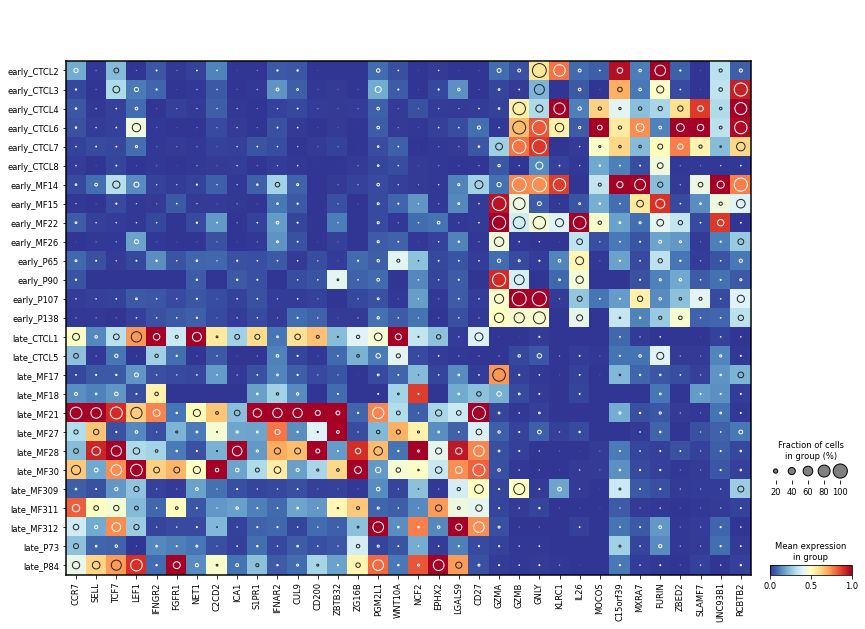

In [12]:
#Show differential gene expression results
genes = ['CCR7','SELL','TCF7','LEF1','IFNGR2','FGFR1','NET1','C2CD2','ICA1','S1PR1','IFNAR2','CUL9','CD200','ZBTB32','ZG16B',
         'PGM2L1','WNT10A','NCF2','EPHX2','LGALS9','CD27',
         'GZMA','GZMB','GNLY','KLRC1','IL26','MOCOS','C15orf39','MXRA7','FURIN','ZBED2','SLAMF7','UNC93B1','RCBTB2']
dp = sc.pl.dotplot(adata_filtered_harmony, var_names=genes, groupby='stage_donor',dendrogram=False,
                   standard_scale='var',use_raw=True,var_group_rotation=0,swap_axes=False,return_fig=True)
dp.style(cmap='RdYlBu_r',color_on='square',dot_edge_color=None,dot_edge_lw=1)
dp.savefig('/home/jovyan/farm/CTCL/script_notebook/figures/Gene_early_late_stage.pdf')

#### Malignant Markers across studies

In [2]:
input_file = '/lustre/scratch117/cellgen/team205/rl20/CTCL/object-new/CTCL_tumourcell_sanger_PKU_Vienna_processed_harmony_rmdou.h5ad'
adata = sc.read_h5ad(input_file)

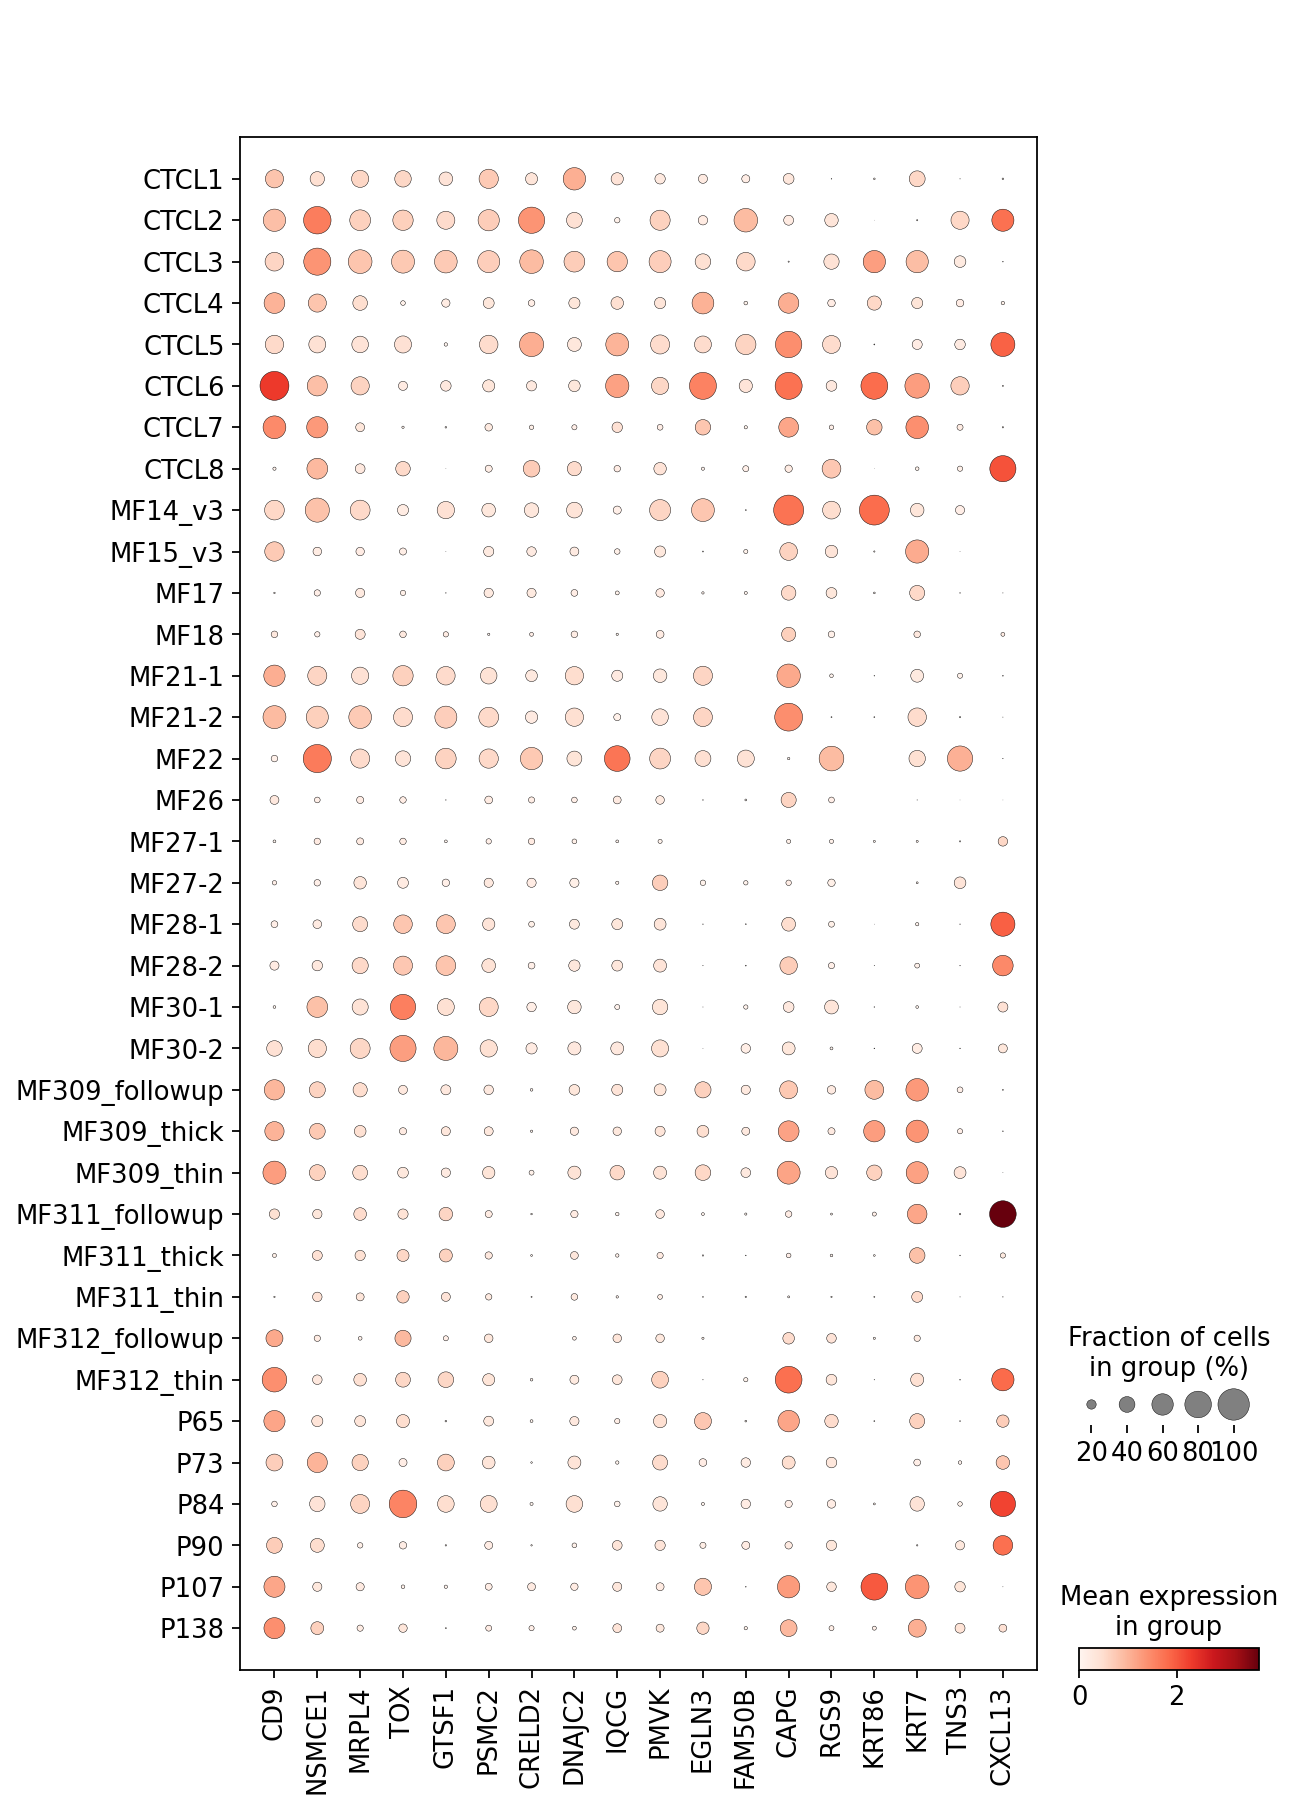

In [3]:
genes = ['CD9', "NSMCE1",'MRPL4','TOX','GTSF1','PSMC2','CRELD2','DNAJC2',
        'IQCG','PMVK','EGLN3','FAM50B','CAPG','RGS9','KRT86', 'KRT7','TNS3','CXCL13']
sc.settings.set_figure_params(dpi=80,facecolor='white')
dp = sc.pl.dotplot(adata, genes, groupby='donor_id',dendrogram=False, color_map='Reds', use_raw=True)